In [1]:
import thinkplot
import thinkstats2
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import scipy.stats as ss
import math

##Seaborn for fancy plots. 
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (15,7)

<b>Note:</b> This was formally #16, we did a little reorganizing. 
<b>注意：</b> 这是正式的 #16，我们进行了一些重组。

<h1>Estimating the Height of a Population</h1>

We want to estimate the height of a population of people. We currently only have a sample of data. What do we do?
<br>
We can ESTIMATE the population using the sample. This is how we can generalize from a subset of data to draw conclusions about everyone, just like a pre-election poll or a survey. Our process will be:
<ul>
<li>Build a analtical distribution based on the values of our sample. 
<li>Use that analytical distribution to run a bunch of trials. 
<li>Use the aggregate of those trials to give an estimate of reality, along with error rates of how much we can trust that estimate.
</ul>

First, we will load and take a little preview of the data. 
<h1>估计人口的高度</h1>

我们想估计人群的身高。我们目前只有一个数据样本。我们做什么？
<br>
我们可以使用样本来估计总体。这就是我们可以从数据子集进行概括以得出关于每个人的结论的方式，就像选举前的民意调查或调查一样。我们的流程将是：
<ul>
<li>根据我们的样本值构建分析分布。
<li>使用该分析分布来运行大量试验。
<li>使用这些试验的汇总来估计现实情况，以及我们可以信任该估计的错误率。
</ul>

首先，我们将加载并预览数据。

In [2]:
#Read Data, make it inches for ease of viewing
df = pd.read_csv("data/h_w_scatter.csv")
df["height"] = df["height"]/2.54
df.head()

,weight,age,height,size
0,62,28.0,68.0,XL
1,59,36.0,66.0,L
2,61,34.0,65.0,M
3,65,27.0,69.0,L
4,62,45.0,68.0,M


##### Note on "Making a Distribution"

Here, when we say something like we are "making a distribution", we're referring to just generating an analytical distribution based on the stats from our data, usually mean and standard distribution. More specifically, we are doing that, then generating a set of random values that match that distribution. 

For example, this line of code generates 1,000 values that follow a normal distribution with a mean of 3 and a std of 1. You can graph it to see what it looks like. Try running it a few times over and over, each distribution will be similar, but slightly different. The higher the number of values, the more consistent it will be, the lower the number of values, the more varaition. Think about why...
##### 关于“分发”的注意事项

在这里，当我们说我们正在“进行分布”时，我们指的是仅根据我们数据的统计数据生成分析分布，通常是均值和标准分布。更具体地说，我们正在这样做，然后生成一组与该分布匹配的随机值。

例如，这行代码生成 1,000 个值，这些值服从均值为 3、标准为 1 的正态分布。您可以将其绘制成图形以查看它的样子。尝试一遍又一遍地运行它，每个分布都会相似，但略有不同。值的数量越高，越一致，值的数量越少，变化越多。想想为什么...
https://www.cnblogs.com/seven18/p/14736429.html

Text(0.5, 1.0, 'Example of a Random Sample')

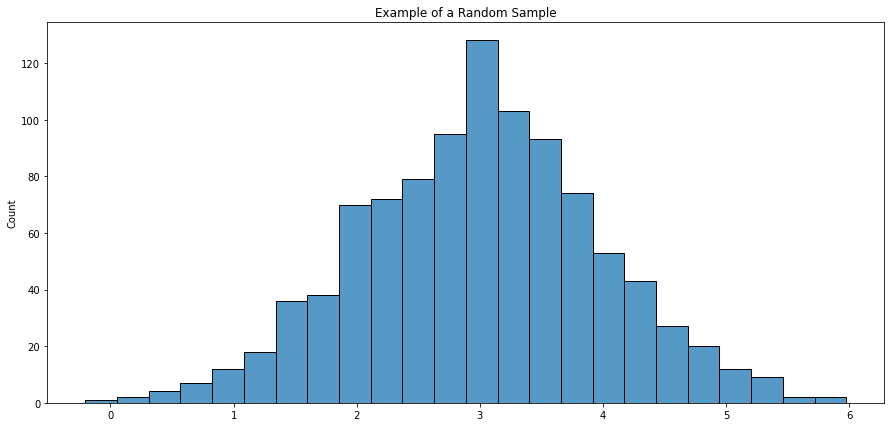

In [3]:
tmp_dist = np.random.normal(3, 1, 1000)
sns.histplot(tmp_dist)
plt.title("Example of a Random Sample")


### Back to our Data - Look at the Distribution

Plot the data. Here we combine the grid from thinkplot, with seaborn graphs - for maximum coolness. 

### 回到我们的数据 - 查看分布

绘制数据。在这里，我们将 thinkplot 中的网格与 seaborn 图表相结合——以获得最大的凉爽。


核密度估计Kernel Density Estimation(KDE)是在概率论中用来估计未知的密度函数，属于非参数检验方法之一。 由于核密度估计方法不利用有关数据分布的先验知识，对数据分布不附加任何假定，是一种从数据样本本身出发研究数据分布特征的方法

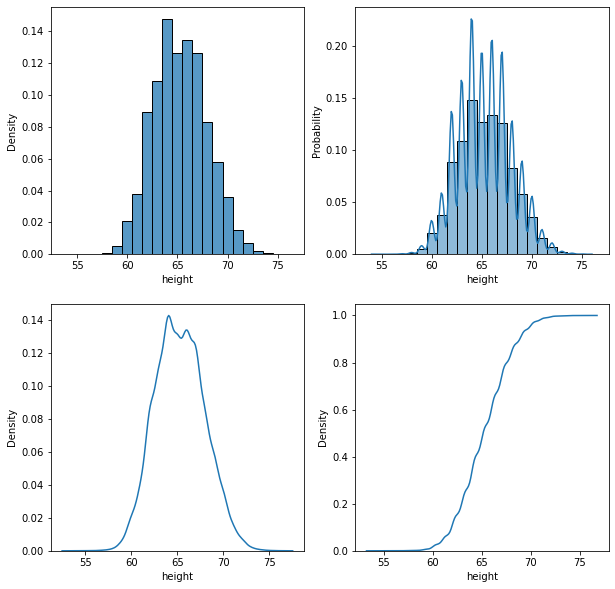

In [4]:
#Visualize - a few ways for fun!
# I'm just doing this for the hell of it, any distribution matching will work 
#Visualize - 几种娱乐方式！
# 我只是为了它而这样做，任何分布匹配都可以
thinkplot.PrePlot(2,2,2)
sns.histplot(x="height", data=df, binwidth=1, discrete=True, stat="density")
thinkplot.SubPlot(2)
sns.histplot(x="height", data=df, kde=True, discrete=True, stat="probability")
thinkplot.SubPlot(3)
sns.kdeplot(x="height", data=df, bw_adjust=2)
thinkplot.SubPlot(4)
sns.kdeplot(x="height", data=df, cumulative=True) #修改为核密度分布  cumulative累积 cdf
thinkplot.Config()

In [5]:
#Get some stats on our data
df["height"].describe()

count    119404.000000
mean         65.277872
std           2.652619
min          54.000000
25%          63.000000
50%          65.000000
75%          67.000000
max          76.000000
Name: height, dtype: float64

<h2>Estimators, an Exploration</h2>

Our goal here is to <b>use what we have to estimate the average height of the population as a whole</b>. To do that we need to take some of our sample statistics and use them to create the estimation. How good are they?

We ideally want unbaised estimators, or ones that will trend towards having an error of 0 if given enough simulations. We can test this with an implementation of the estimation game from the book - here we just have a function that is customizable with any mu/sigma for a normal distribution. We can take our statistics, and run the estimation game over and over. If the average difference of the trial runs from the real sample values is small, we have pretty good estimators. 

We will implement the estimation game from the book. Below is very similar to what is in the first part of ch8. 

The normalEstimates function below does a few things:
<ul>
<li>Takes the stats from our data. 
<li>Generates a bunch of random numbers following a normal distribution based on that. 
<li>Tallys how close to the real data a bunch of stats of that distribution are.
</ul>
<h2>估算器，一种探索</h2>

我们的目标是<b>使用我们所拥有的东西来估计整个人口的平均身高</b>。为此，我们需要获取一些样本统计数据并使用它们来创建估计。他们有多好？

理想情况下，我们希望得到无基础的估计量，或者如果给出足够的模拟，误差趋向于 0 的估计量。我们可以用书中的估计游戏的实现来测试这一点——这里我们只有一个函数，可以用任何 mu/sigma 来定制正态分布。我们可以获取我们的统计数据，并一遍又一遍地运行估计游戏。如果试运行与实际样本值的平均差异很小，我们就有很好的估计量。

我们将实现书中的估计游戏。下面的内容与 ch8 的第一部分非常相似。

下面的 normalEstimates 函数做了一些事情：
<ul>
<li>从我们的数据中获取统计信息。
<li>在此基础上按照正态分布生成一堆随机数。
<li>统计该分布的一系列统计数据与真实数据的接近程度。
</ul>
Think - if we were to create an estimated distribution, we'd probably want it to reflect the real data, on average. E.g. we wouldn't want the analytical distribution to have a mean that is always way larger or way smaller than the mean of our data. So, if we run a bunch of trial ones, the mean of the analytical trials should trend to be the same as the mean of our data, the median should trend to be the same as our data, the standard deviation, etc...

This step is strictly exploraatory - we are looking to see if we are introducing any bias/error into our estimation right off the bat. We can also use this to select our estimators. E.g. if the median tended to be less biased than the mean, we could (try to) use that to create the distribution. Or if we had some other reasoning (e.g. domain knowledge) we may look to have another estimator. The n-1 vs n argument is mostly academic, don't worry about it too much, the book has a few details, but largely refers to wikipedia for an explaination - we'll touch on this a little more later with hypothesis testing, it is more of a theoretical concern than a practical one. 

In practice, we'll probably just use the mean and standard deviation in most cases to create our distributions. 


想想 - 如果我们要创建一个估计分布，我们可能希望它平均反映真实数据。例如。我们不希望分析分布的平均值总是比我们数据的平均值大或小。所以，如果我们运行一堆试验，分析试验的平均值应该与我们数据的平均值相同，中位数应该与我们的数据相同，标准差等......

这一步是严格的探索性的——我们正在寻找是否立即在我们的估计中引入任何偏差/错误。我们也可以使用它来选择我们的估计器。例如。如果中位数的偏差往往小于平均值，我们可以（尝试）使用它来创建分布。或者，如果我们有一些其他的推理（例如领域知识），我们可能会寻找另一个估计器。 n-1 vs n 的争论主要是学术性的，不要太担心，这本书有一些细节，但主要是参考维基百科来解释——我们稍后会通过假设检验来讨论这个问题，与其说是实际问题，不如说是一种理论问题。

在实践中，在大多数情况下，我们可能只使用均值和标准差来创建我们的分布。

In [6]:
def MeanError(estimates, actual):
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

##### Normal Estimates

This function just takes in a mean and standard deviation, generates "iters" normal distributions, then tallies up their basic statistics. 
##### 正常估计

这个函数只接受平均值和标准差，生成“迭代”正态分布，然后计算它们的基本统计数据。

In [7]:
#Estimations for a normal distribution#正态分布的估计
def normalEstimates(mu=0, median=0, sigma=1, n=1000, iters=1000):
    estimates1 = []
    estimates2 = []
    means = []
    medians = []
    for _ in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
        xmed = np.median(xs)
        medians.append(xmed)
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error (biased) S2', MeanError(estimates1, sigma**2))
    print('mean error (unbaised) S2(n-1)', MeanError(estimates2, sigma**2))
    print('mean error means', MeanError(means, mu))
    print('mean error medians', MeanError(medians, median))

#### Run Some Trials

Now we'll generate some trials. What is happening here is that we generate 10 distributions, and compare their calculated mean/median/std to the inputs we used to make them. That difference is the error, or how much the random generated numbers differ from the inputs. Then we generate 100, and repeat, then 1000, and 10,000.  
#### 运行一些试验

现在我们将生成一些试验。这里发生的是我们生成了 10 个分布，并将它们计算的均值/中值/标准差与我们用来制作它们的输入进行比较。该差异就是错误，或者随机生成的数字与输入的差异有多大。然后我们生成 100，然后重复，然后是 1000，然后是 10,000。

In [8]:
#Run some estimator estimation for our data
print("10 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=10)
print("100 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=100)
print("1000 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=1000)
print("10000 Trials")
normalEstimates(mu=df["height"].mean(), median=df["height"].median(), sigma=df["height"].std(), n=df["height"].count(), iters=10000)

10 Trials
mean error (biased) S2 0.009528491830972374
mean error (unbaised) S2(n-1) 0.009587501350115612
mean error means 0.0023348066238526146
mean error medians 0.2788238479924914
100 Trials
mean error (biased) S2 0.003553713048963072
mean error (unbaised) S2(n-1) 0.0036126725293401662
mean error means 0.0006505848641941724
mean error medians 0.27814642568451103
1000 Trials
mean error (biased) S2 0.00031974053325033847
mean error (unbaised) S2(n-1) 0.0003786729291110671
mean error means 0.00015570624515932253
mean error medians 0.2777076566965698
10000 Trials
mean error (biased) S2 -4.732117840262697e-05
mean error (unbaised) S2(n-1) 1.1608143316646302e-05
mean error means -6.781866932708454e-05
mean error medians 0.2777872543250877


As we run more and more trials, we should see the average errors getting closer to 0. That's good, it means that we can produce estimates that introduce less error. If the opposite was 

So what we have above is basically how much error we should expect from each of these metrics vs our actual data. For ours, we can see that the mean and the (n-1) standard distribution yeild the lowest errors. So basing our fake normal distribution on these will introduce the lowest amount of error. 

##### Estimator Choice

Which estimators to use is generally something that will be pretty simple for us in practice - we can look it up and it will probably be the "main paramater" - like the mean in a normal distribution. There is a fair bit of math behind this, the book touches on it a little (though not in depth either), but we generally don't need it. The critical idea for us is that <b>using an estimator that doesn't introduce error means that we don't add error to our estimations that is inheirient to the process.</b> We still have error, but it isn't coming from the "math", it is coming from the data. 

<h3>Sampling Distributions</h3>
随着我们进行越来越多的试验，我们应该看到平均误差越来越接近 0。这很好，这意味着我们可以生成引入更少误差的估计。如果相反的是

所以我们上面得到的基本上是我们应该从这些指标中的每一个与我们的实际数据中期望多少误差。对于我们来说，我们可以看到均值和 (n-1) 标准分布产生的误差最低。因此，将我们的假正态分布基于这些将引入最低量的错误。

##### 估计器选择

在实践中，使用哪些估计器通常对我们来说非常简单——我们可以查找它，它可能是“主要参数”——就像正态分布中的平均值一样。这背后有相当多的数学知识，本书稍微涉及到它（虽然也没有深入），但我们通常不需要它。对我们来说，关键的想法是<b>使用不会引入错误的估计器意味着我们不会在我们的估计中添加与过程无关的错误。</b>我们仍然有错误，但事实并非如此。 t 来自“数学”，它来自数据。

<h3>抽样分布</h3>

In [9]:
#Simulate normal distribution based on estimators from sample
#This is the same as the book's example (8.3), but customizable a bit more and uses external error calcs. 

#根据样本中的估计量模拟正态分布
#这与本书的示例（8.3）相同，但可定制更多，并使用外部错误计算。
def simulateNormal(mu=0, sigma=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = []
    for j in range(m):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        means.append(xbar)
    cdf = thinkstats2.Cdf(means)
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    muList = [mu] * m
    stderr = mean_squared_error(means, muList, squared=False) #squared=False is RMSE
    return cdf, ci, stderr

<h2>Generating an Estimate - Here's the big part!</h2>

We can now make our estimates!! What are we doing here?

- Make a distribution from our sample statistics - mean and std. 

- Compare the difference in means from the simulated distribution and our sample mean. A bunch of times. 

- Create a cdf of those means. 

- Calculate the 5% and 95% percentiles of the predicted means, those are the confidence interval limits. 
<h2>生成估算 - 这是重要的部分！</h2>

我们现在可以进行估算了！！我们在这里做什么？

- 根据我们的样本统计数据进行分布 - 平均值和标准差。

- 比较模拟分布和我们的样本均值的均值差异。好几次。

- 创建这些手段的 cdf。

- 计算预测均值的 5% 和 95% 百分位数，即置信区间限制。

### In Other Words

We are creating N number of analytical distributions based on the statistics from the emperical data - this is what is being done inside of the loop of the function above. We are then collecting the means of all of those distributions and putting them in a list, so if n=1000, the list of means is the 1000 mean values of each distribution we created. 

Once we have a list of means, that is used to generate our estimation of the mean for the population, which is what the back half is doing. We've estimated the mean 1000 times, and we are looking for the distribution of those means. Each mean will vary a little - some a bit higher, some a bit lower, we can take the set of means and make a CDF for it - this will show how many of those fake means take on each value. Most will (usually) be clustered around a central point, some will diverge a little more. 

<b>Note:</b> this isn't the distribution of the original data. This is the distribution of the mean values from the analytical datasets that we created from the original data. 

<b>Note 2:</b> if you look at the confidence interval that we are using in the print statements, there's an index there. The function returns that value as a tuple of two values. The first is the lower, the second is the higher, so we use the index to grab the correct one. 
＃＃＃ 换句话说

我们正在根据来自经验数据的统计数据创建 N 个分析分布 - 这就是在上述函数的循环内部所做的事情。然后我们收集所有这些分布的均值并将它们放入一个列表中，因此如果 n=1000，则均值列表是我们创建的每个分布的 1000 个平均值。

一旦我们有了一个均值列表，就可以用来生成我们对总体均值的估计，这就是后半部分正在做的事情。我们已经估计了平均值 1000 次，我们正在寻找这些平均值的分布。每个均值都会有所不同——有些高一些，有些低一些，我们可以采用一组均值并为它制作一个 CDF——这将显示每个值有多少假均值。大多数将（通常）聚集在一个中心点周围，有些会更加分散。

<b>注意：</b>这不是原始数据的分布。这是我们从原始数据创建的分析数据集中平均值的分布。

<b>注意 2：</b> 如果您查看我们在打印语句中使用的置信区间，就会发现那里有一个索引。该函数将该值作为两个值的元组返回。第一个是较低的，第二个是较高的，所以我们使用索引来抓取正确的。

Standard Error: 0.007745714760874025
Low CI: 65.26553935977823
Hi CI: 65.29067287271594
Mean of Means: 65.27791023447361


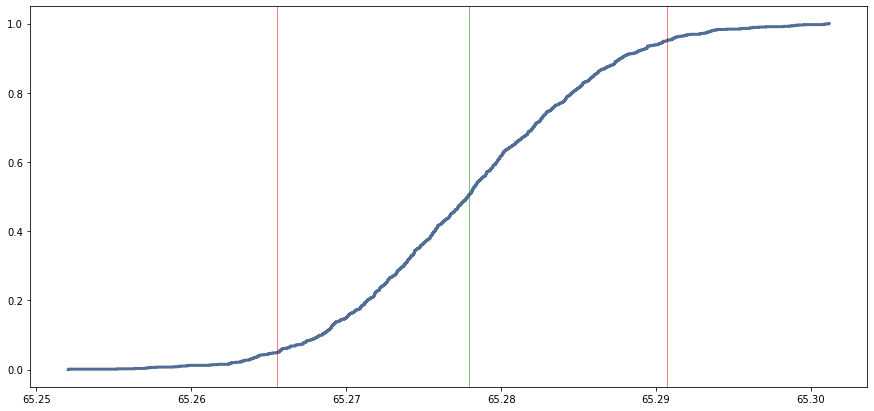

In [10]:
#Produce estimates - change the n and trials and observe results
mu = df["height"].mean()
sigma = df["height"].std()
n = df["height"].count()

cdf, ci, stderr = simulateNormal(mu=mu, sigma=sigma, n=n, m=1000, ciLow=5, ciHi=95)
print("Standard Error:", stderr)
print("Low CI:", ci[0])
print("Hi CI:", ci[1])
print("Mean of Means:", cdf.Mean())
thinkplot.Cdf(cdf)
thinkplot.axvline(cdf.Mean(), color="green")
thinkplot.axvline(ci[0], color="red")
thinkplot.axvline(ci[1], color="red")
thinkplot.Config()

<h2>We Have an Estimate!</h2><h2>我们有一个估计！</h2>

![Thanks Obama](images/thanks_obama.gif "Thanks Obama")

Where are we?

We took our sample of height and tried to use it to estimate the overall population's height parameter. 
Our sample looks pretty normal visually, so we generalized from the normal distribution in our data to the normal distribution of the population. 
We computed the relevant statistics to act as estimators for this inference - mean and standard devitation. 
We assumed that those statistics translated to the population, and used them to create an analytical normal distribution with those properties.
We ran multiple trials of creating a distribution at random, and tracked the results, yeilding...
我们在哪？

我们提取了身高样本，并尝试用它来估计总体人口的身高参数。
我们的样本在视觉上看起来很正常，因此我们从数据中的正态分布推广到总体的正态分布。
我们计算了相关统计数据以作为该推断的估计量 - 均值和标准差。
我们假设这些统计数据转化为总体，并使用它们来创建具有这些属性的分析正态分布。
我们进行了多次随机创建分布的试验，并跟踪结果，产生...
- A measure of the standard error - our sample differed from the theoretical by a certain amount, on average.

- A multitude of predictions for the distribution, and the resulting mean, plotted in our cdf/pmf chart.

- Confidence intervals, where the middle 90% of our expected means will lie. 

Overall, this particular estimation looks pretty solid. Our data is pretty normal, the mean and median are quite similar. When running trials, we get a fairly constrained range of confidence intervals and the standard error is low (a real evaluation of "low" requires some domain knowledge) 
What does this mean? As long as the sample that we took was actually representitive of the population data, this estimation is likely quite good!

(We've done an OK job estimating the height of the female population of Estonia!)

- 衡量标准误差 - 我们的样本平均与理论值有一定的差异。

- 在我们的 cdf/pmf 图表中绘制了对分布的大量预测，以及由此产生的平均值。

- 置信区间，即我们预期均值的中间 90%。

总的来说，这个特定的估计看起来相当可靠。我们的数据很正常，平均值和中位数非常相似。在运行试验时，我们得到了相当有限的置信区间范围，并且标准误差很低（对“低”的真正评估需要一些领域知识）
这是什么意思？只要我们采集的样本实际上代表了人口数据，这个估计就可能相当不错！

（我们在估计爱沙尼亚女性人口的身高方面做得很好！）

<h2>Error</h2>

Above, we determined how much error we can expect in our estimate, but we only accounted for the <b>Sampling Error</b> - or error due to dealing with a limited subset of data. We can also look at this as, "given the data we have, how accurate/reliable of an estimate can we make?". In addition to this, there are other sources of error, we can't control them here!
<h3>Sampling Bias</h3>
Sampling Bias is error due to the fact that our sample that we have been given could be off, or non-representative. It is impossible to get a truly random sample of the population, so some error is introduced here. Maybe the areas where we got responses were richer than average, so they have better nutrition, so they are taller... Maybe the people who answered the phone are older than average and have started shrinking, etc... The actual sample we get will hopefully closely match the population, and statisticians take a lot of care to both ensure this and compensate for it, but it will never be perfect. 
<h3>Measurement Error</h3>
Measurement Error comes from issues with collecting the data. Meaurements aren't perfect, people who respond to surveys don't always give perfect data, people meauring their heights round up, etc... No matter what we are measuring, we rarely have perfectly accurate data going in, that introduces some error. 

We can attempt to reduce the sampling error, but the other two may overwhelm it! 
<h2>错误</h2>

上面，我们确定了我们在估计中可以预期的误差，但我们只考虑了<b>采样误差</b> - 或由于处理有限的数据子集而导致的误差。我们也可以将其视为“鉴于我们拥有的数据，我们可以做出多准确/可靠的估计？”。除此之外，还有其他的错误来源，我们这里无法控制！
<h3>抽样偏差</h3>
抽样偏差是错误的，因为我们提供的样本可能是关闭的或不具代表性的。不可能得到一个真正随机的总体样本，所以这里引入了一些错误。也许我们得到回应的区域比平均水平更丰富，所以他们有更好的营养，所以他们更高......也许接听电话的人比平均水平更老，并且已经开始萎缩等等......我们得到的实际样本希望将与人口紧密匹配，统计学家会非常小心地确保这一点并对其进行补偿，但它永远不会完美。
<h3>测量误差</h3>
测量误差来自收集数据的问题。测量并不完美，回答调查的人并不总是给出完美的数据，测量身高的人会四舍五入，等等......无论我们测量什么，我们很少有完全准确的数据进入，这会引入一些错误.

我们可以尝试减少采样误差，但其他两个可能会压倒它！
<br><br>

### Results in "Polling Language"

<b>"This Poll is Accurate to within 2.4%, 19 times out of 20..."</b>

If we want to express our results in a political poll style format...
### 结果为“轮询语言”

<b>“此民意调查的准确度在 2.4% 以内，20 次中有 19 次...”</b>

如果我们想以政治投票风格的形式表达我们的结果......

In [11]:
#Expressed in terms of +/- 19 times out of 20, like polling results
middle = round((ci[0]+ci[1])/2, 3)
plusMin = round(ci[1]-middle, 3)
print("Average person is: "+str(middle)+" Inches Tall +/- "+str(plusMin)+", 18 times out of 20.")

#Why 18/20? We have the middle 90% (from 5% to 95%) for the CI range. 18/20 = 90%

Average person is: 65.278 Inches Tall +/- 0.013, 18 times out of 20.


#### Results

This is our generalization - we have taken the height data, used it to estimate for the entire population, and calculated how much error we can reasonably expect in doing so!
＃＃＃＃ 结果

这是我们的概括——我们获取了身高数据，用它来估计整个人口，并计算出我们可以合理预期的误差有多大！

## Exercise - How big are brains?

<b>Note:</b> There's a sample solution in the sol file, and this follows the same basic pattern as the example above. Try to attempt it without having steps defined as much as possible, and refer back to those or unmute and ask me if there's an issue. 

We can look at another one, brain size. Obviously gettting actual real brains to measure isn't the most practical, given the whole 'skull' thing getting in the way. 

##### Try to Calculate the Average Brain Weight of the Population and the Confidence Intervals
## 锻炼 - 大脑有多大？

<b>注意：</b> sol 文件中有一个示例解决方案，它遵循与上面示例相同的基本模式。尝试在没有尽可能多地定义步骤的情况下尝试它，然后参考这些步骤或取消静音并询问我是否有问题。

我们可以看看另一个，大脑大小。显然，让真正的大脑来测量并不是最实用的，因为整个“头骨”的东西都会挡住。

##### 尝试计算人群的平均脑重和置信区间

In [12]:
#Load the data
#Also relabel the column, for ease of typing
brain = pd.read_csv("data/brain.csv")
brain = brain.rename(columns={"Brain Weight(grams)":"Weight", "Head Size(cm^3)":"Size"})
brain.head()

,Gender,Age Range,Size,Weight
0,1,1,4512,1530
1,1,1,3738,1297
2,1,1,4261,1335
3,1,1,3777,1282
4,1,1,4177,1590


In [13]:
#Take a peek at the varaibles
brain.describe()

,Gender,Age Range,Size,Weight
count,237.000000,237.000000,237.000000,237.000000
mean,1.434599,1.535865,3633.991561,1282.873418
std,0.496753,0.499768,365.261422,120.340446
min,1.000000,1.000000,2720.000000,955.000000
25%,1.000000,1.000000,3389.000000,1207.000000
50%,1.000000,2.000000,3614.000000,1280.000000
75%,2.000000,2.000000,3876.000000,1350.000000
max,2.000000,2.000000,4747.000000,1635.000000


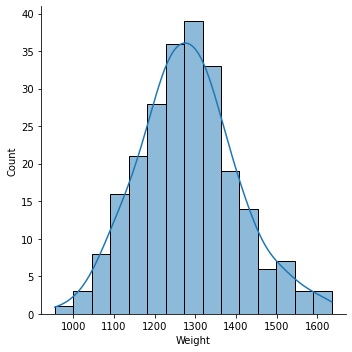

In [14]:
#visualize the distribution
sns.displot(data=brain, x="Weight", kde=True)

Looks pretty normal. We can use this knowledge to estimate the brain size of everyone!!!!
看起来很正常。我们可以利用这些知识来估计每个人的大脑大小！！！！

In [15]:
#Get some basic brain stats and save them in varaibles.
#mean, standard dev, median, and count. 

#获取一些基本的大脑统计数据并将它们保存在变量中。
#mean、标准差、中位数和计数。
mu2 = brain["Weight"].mean()
sigma2 = brain["Weight"].std()
n2 = brain["Weight"].count()
med2 = brain["Weight"].median()

print("Mean:", mu2)
print("Med:", med2)
print("Std:", sigma2)
print("N:", n2)

Mean: 1282.873417721519
Med: 1280.0
Std: 120.34044578645724
N: 237


Create some distributions based on the stats we just calculated, run some trial runs. We could do the estimator trials here to see if we get any better estimators. 

根据我们刚刚计算的统计数据创建一些分布，运行一些试运行。我们可以在这里进行估计器试验，看看是否能得到更好的估计器。

Standard Error: 7.825010081466938
Low CI: 1270.0897738659035
Hi CI: 1295.78445440078
Estimate: 1282.9128700112228


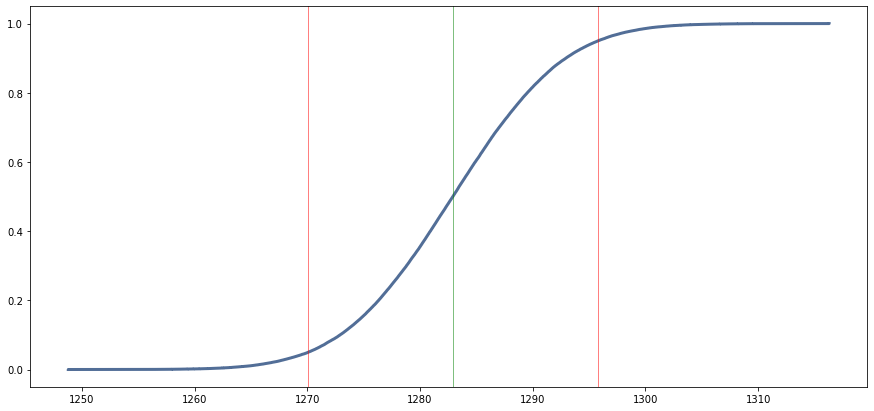

In [16]:
#Generate some trials using the normal simulator like last time. 
#Print the error, confidence intervals, and graph. 
#像上次一样使用普通模拟器生成一些试验。
#打印误差、置信区间和图表。
cdf2, ci2, stderr2 = simulateNormal(mu=mu2, sigma=sigma2, n=n2, m=100000, ciLow=5, ciHi=95)
print("Standard Error:", stderr2)
print("Low CI:", ci2[0])
print("Hi CI:", ci2[1])
print("Estimate:", cdf2.Mean())
thinkplot.Cdf(cdf2)
thinkplot.axvline(cdf2.Mean(), color="green")
thinkplot.axvline(ci2[0], color="red")
thinkplot.axvline(ci2[1], color="red")

What can we conclude about the brain size of the population as a whole based on this? How is our estimate? 
基于此，我们可以得出关于整个人口的大脑大小的什么结论？我们的估计如何？

<h2>Exponential Distributions</h2>
Normal distributions are probably the most common, but we can apply the same process to other distributions. 

E.g. Exponential - We just need to adjust the creation of the distribution's random varaibles. 
<ul>
<li>Note: If you're doing this with an odd distribution, and the paramaters are not as simple as "mean", the easiest self check is to create the CDF and PDF of your data, then create the same of the sample data (with a large n), and compare. They should be reasonably close to each other. If the analytical random one is more or less the same as the original data, you probably haven't made a fundamental mistake
</ul>

For an exponential distribution we only need the mean to generate the analytical ones. The value that we actually need is generally labeled lambda, but it is just 1/mean so we can calculate it. 

<h2>指数分布</h2>
正态分布可能是最常见的，但我们可以将相同的过程应用于其他分布。

例如。指数 - 我们只需要调整分布的随机变量的创建。
<ul>
<li>注意：如果您使用奇数分布执行此操作，并且参数不像“均值”那么简单，最简单的自检是创建数据的 CDF 和 PDF，然后创建相同的样本数据（n 很大），然后进行比较。它们应该合理地彼此靠近。如果分析随机数与原始数据或多或少相同，则您可能没有犯根本性错误
</ul>

对于指数分布，我们只需要生成分析分布的平均值。我们实际需要的值通常标记为 lambda，但它只是 1/mean，因此我们可以计算它。

在概率论和统计学中，指数分布（Exponential distribution）是一种连续概率分布。 指数分布可以用来表示独立随机事件发生的时间间隔，比如旅客进机场的时间间隔、中文维基百科新条目出现的时间间隔等等。 许多电子产品的寿命分布一般服从指数分布。 有的系统的寿命分布也可用指数分布来近似。

In [17]:
#Exponential simulator
def simulateExp(mean=1, n=100, m=10000, ciLow=5, ciHi=95):
    means = []
    for j in range(m):
        xs = np.random.exponential(1/mean,n)
        xbar = 1/np.mean(xs)
        means.append(xbar)
    cdf = thinkstats2.Cdf(means)
    ci = cdf.Percentile(ciLow), cdf.Percentile(ciHi)
    rateList = [mean] * m
    stderr = mean_squared_error(means, rateList, squared=False)
    return cdf, ci, stderr

The exponential simulation is basically the same as the normal one. We just need to do the appropriate work to create an exponential distribution instead of a normal one. 
指数模拟与普通模拟基本相同。我们只需要做适当的工作来创建指数分布而不是正态分布。

Standard Error: 0.7335636388433346
Low CI: 1.307353117492786
Hi CI: 3.4583140284275395
Estimate: 2.1888414872122306


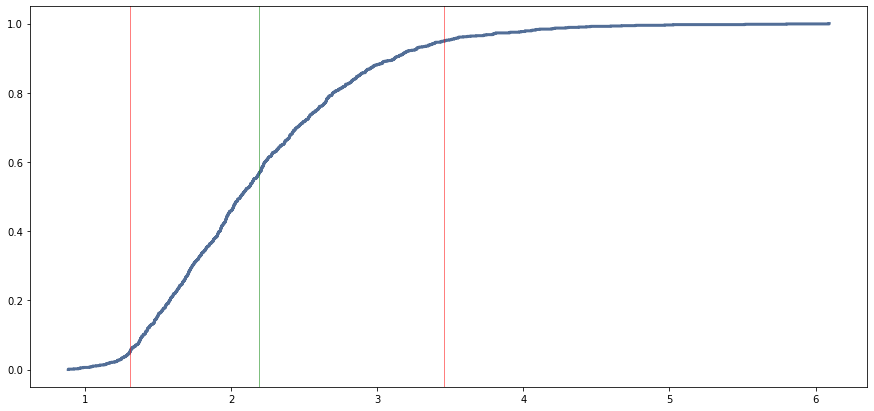

In [18]:
#Run a dummy one.... 
#运行一个假人......
cdf3, ci3, stderr3 = simulateExp(mean=2, n=10, m=1000, ciLow=5, ciHi=95)
print("Standard Error:", stderr3)
print("Low CI:", ci3[0])
print("Hi CI:", ci3[1])
print("Estimate:", cdf3.Mean())
thinkplot.Cdf(cdf3)
thinkplot.axvline(cdf3.Mean(), color="green")
thinkplot.axvline(ci3[0], color="red")
thinkplot.axvline(ci3[1], color="red")
thinkplot.Config()

#### Results

Note the estimate here isn't dead center between the two CI lines like we saw with normal distributions above. The exponential distribution is not symetrical, so we don't get the same pattern. 
＃＃＃＃ 结果

请注意，这里的估计值并不是我们在上面的正态分布中看到的两条 CI 线之间的死点。指数分布不是对称的，所以我们没有得到相同的模式。

<h3>Real example - Load employee dataset</h3>

We are going to look at the column "stag" - it is a measure of how long an employee stays at a job. It is roughly exponential like the interarrival time in chapter 5. In terms of total numbers, most people quit right away, then it kind of flattens out. 

The stag value is in months of employment. 

<b>How long should we expect a typical employee to last?</b>
<h3>实例——加载员工数据集</h3>

我们将查看“stag”列 - 它衡量员工在工作中停留的时间。它与第 5 章中的到达间隔时间大致呈指数关系。就总数而言，大多数人立即退出，然后就趋于平缓。

雄鹿价值以就业月数为单位。

<b>我们应该期望一个典型的员工能坚持多久？</b>

In [19]:
dfEmp = pd.read_csv("data/turnover.csv",encoding = "ISO-8859-1")
dfEmp.describe()

,stag,event,age,extraversion,independ,selfcontrol,anxiety,novator
count,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000,1129.000000
mean,36.627526,0.505757,31.066965,5.592383,5.478034,5.597254,5.665633,5.879628
std,34.096597,0.500188,6.996147,1.851637,1.703312,1.980101,1.709176,1.904016
min,0.394251,0.000000,18.000000,1.000000,1.000000,1.000000,1.700000,1.000000
25%,11.728953,0.000000,26.000000,4.600000,4.100000,4.100000,4.800000,4.400000
50%,24.344969,1.000000,30.000000,5.400000,5.500000,5.700000,5.600000,6.000000
75%,51.318275,1.000000,36.000000,7.000000,6.900000,7.200000,7.100000,7.500000
max,179.449692,1.000000,58.000000,10.000000,10.000000,10.000000,10.000000,10.000000


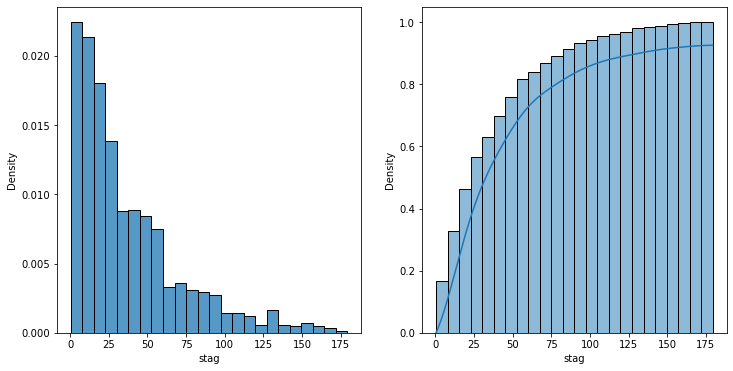

In [20]:
#Look at the distribution 
thinkplot.PrePlot(2,1,2)
sns.histplot(dfEmp["stag"], stat="density")
thinkplot.SubPlot(2)
sns.histplot(dfEmp["stag"], stat="density", cumulative=True, kde=True)
thinkplot.Config()

In [21]:
#Average time at a job - Looks ok. 
meanExp = dfEmp["stag"].mean()
countExp = dfEmp["stag"].count()
meanExp, countExp

(36.62752558551998, 1129)

##### Looks kind of exponentially distributed! Let's get it!!

<b>Note:</b> There are lots of distributions, and sometimes one may look like, "oh, this actually looks like X distribution". The ideas behind all of this stuff is the same no matter the distribution, we focus on normal (and varieties) because it is common, and other common different ones like exponential. Expanding this to other data that fits different distributions differs only in the mechanics. 
##### 看起来呈指数分布！我们去取得它！！

<b>注意：</b> 有很多分布，有时可能看起来像，“哦，这实际上看起来像 X 分布”。无论分布如何，所有这些东西背后的想法都是相同的，我们专注于正态（和变体），因为它很常见，以及其他常见的不同的，比如指数。将此扩展到适合不同分布的其他数据仅在机制上有所不同。

Estimate: 36.659742243955755
Standard Error: 1.0931398379028843
Low CI: 35.276423711606334
Hi CI: 38.074543216122514
Estimate to CI distance: 1.3833185323494206 -1.4148009721667592


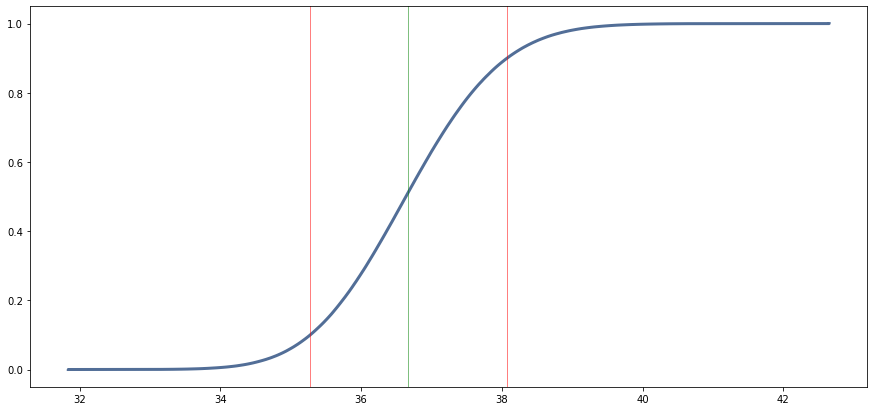

In [22]:
#Create exponential samples using the above function. #使用上述函数创建指数样本。
cdfEmp, ciEmp, stderrEmp = simulateExp(mean=meanExp, n=countExp, m=1000000, ciLow=10, ciHi=90)
print("Estimate:", cdfEmp.Mean())
print("Standard Error:", stderrEmp)
print("Low CI:", ciEmp[0])
print("Hi CI:", ciEmp[1])
print("Estimate to CI distance:", cdfEmp.Mean()-ciEmp[0], cdfEmp.Mean()-ciEmp[1])
thinkplot.Cdf(cdfEmp)
thinkplot.axvline(cdfEmp.Mean(), color="green")
thinkplot.axvline(ciEmp[0], color="red")
thinkplot.axvline(ciEmp[1], color="red")
thinkplot.Config()

Look reasonable?
看起来合理吗？